
# Homework 1

In [1]:
!python -V

Python 3.12.7


In [2]:
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

## Q1. Downloading the data
Download the data for January and February 2023
Read the data for January. How many columns are there?

In [3]:
df = pd.read_parquet('./data/yellow_tripdata_2023-01.parquet',engine='pyarrow')

In [4]:
df[['tpep_pickup_datetime','tpep_dropoff_datetime','PULocationID','DOLocationID','trip_distance']].head(5)
#f[['lpep_pickup_datetime','lpep_dropoff_datetime','PULocationID','DOLocationID','trip_distance']].head(5)

,tpep_pickup_datetime,tpep_dropoff_datetime,PULocationID,DOLocationID,trip_distance
0,2023-01-01 00:32:10,2023-01-01 00:40:36,161,141,0.97
1,2023-01-01 00:55:08,2023-01-01 01:01:27,43,237,1.10
2,2023-01-01 00:25:04,2023-01-01 00:37:49,48,238,2.51
3,2023-01-01 00:03:48,2023-01-01 00:13:25,138,7,1.90
4,2023-01-01 00:10:29,2023-01-01 00:21:19,107,79,1.43


In [5]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [6]:
len(df.columns)

19

## Q2. Computing duration
What is the standard deviation of the trips duration in January?


In [7]:
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
#df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
df['duration'] = df['duration'].dt.total_seconds() / 60
#df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
df['duration'].describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

In [8]:
std_duration =  df['duration'].std()
print(f"{std_duration:.2f} minutes")

42.59 minutes


## Q3. Dropping outliers
Next, we need to check the distribution of the duration variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).
What fraction of the records left after you dropped the outliers?

In [9]:
total_count = df['duration'].count()
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
percentage = 100 * df['duration'].count() / total_count
print(f"{percentage:.2f}%")

98.12%


## Q4. One-hot encoding
Let's apply one-hot encoding to the pickup and dropoff locations IDs. We'll use only these two features for our model.
- Turn the dataframe into a list of dictionaries(remember to re-cast the ids to strings - otherwise it will label encode them)
- Fit a dictionary vectorizer
- Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)

In [10]:
df[['PULocationID', 'DOLocationID', 'trip_distance']].describe()

,PULocationID,DOLocationID,trip_distance
count,3.009173e+06,3.009173e+06,3.009173e+06
mean,1.666243e+02,1.645131e+02,3.783685e+00
std,6.424609e+01,6.989129e+01,2.519560e+02
min,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.320000e+02,1.140000e+02,1.090000e+00
50%,1.620000e+02,1.620000e+02,1.800000e+00
75%,2.340000e+02,2.340000e+02,3.300000e+00
max,2.650000e+02,2.650000e+02,2.589281e+05


In [11]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
df[categorical] = df[categorical].astype(str)

In [12]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
print("Dimensionality", X_train.shape[1])

Dimensionality 516


## Q5. Training a model
Now let's use the feature matrix from the previopus step to train a model.
- Train a plain linear regression model with default parameters, where duration is the response variable
-  Calculate the RMSE of the model on the training data

What's the RMSE on train?

In [13]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
rmse = root_mean_squared_error(y_train, y_pred)
print(f"RMSE = {rmse:.2f} minutes")

RMSE = 7.66 minutes


In [14]:
#sns.distplot(y_pred, label='Prediction')
#sns.distplot(y_train, label='Actual')
#plt.legend()

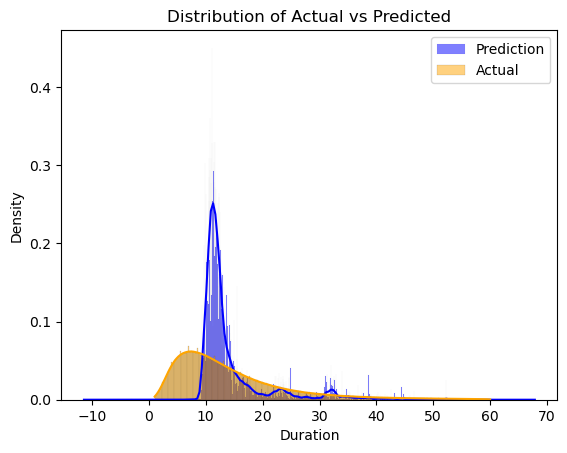

In [15]:
sns.histplot(y_pred, label='Prediction', kde=True, stat="density", color="blue")
sns.histplot(y_train, label='Actual', kde=True, stat="density", color="orange")
plt.legend()
plt.xlabel("Duration")
plt.ylabel("Density")
plt.title("Distribution of Actual vs Predicted")
plt.show()

## Q6. Evaluating the model
Now let's applyt this model to the valitadion dataset (February 2023).

What's the RMSE on validation?

In [16]:
def read_dataframe(filename):
    if filename.endswith('.cvs'):
        df = pd.read_parquet(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
        #df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        #df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename, engine='pyarrow')

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    #df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df['duration'].dt.total_seconds() / 60

    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [18]:
df_train = read_dataframe('./data/yellow_tripdata_2023-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2023-02.parquet')

In [19]:
(df_train.shape), (df_val.shape), (df.shape)

((3009173, 20), (2855951, 20), (3009173, 20))

In [20]:
#df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
#df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [21]:
#categorical = ['PU_DO'] # ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [22]:
X_train.shape

(3009173, 516)

In [23]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"RMSE = {rmse:.3f}")

RMSE = 7.820 minutes


In [26]:
with open('./01-intro/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [ ]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print(f"Lasso RMSE = {rmse:.3f}")

Lasso RMSE = 8.138 minutes
